In [1]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
#import talib
import yfinance as yf

In [18]:
nasdaq_ticker = "^IXIC"  # NASDAQ index ticker symbol
nse_ticker = "^NSEI"  # NSE index ticker symbol

start_date = "2010-01-01"
end_date = "2023-06-01"

# Collect historical data for NASDAQ index
nasdaq_data = yf.download(nasdaq_ticker, start=start_date, end=end_date)['Close']

# Collect historical data for NSE index
nse_data = yf.download(nse_ticker, start=start_date, end=end_date)['Close']

#print(nasdaq_data.head())
#nse_data.head()

columns = nasdaq_data.index
print(columns)

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
DatetimeIndex(['2010-01-04', '2010-01-05', '2010-01-06', '2010-01-07',
               '2010-01-08', '2010-01-11', '2010-01-12', '2010-01-13',
               '2010-01-14', '2010-01-15',
               ...
               '2023-05-17', '2023-05-18', '2023-05-19', '2023-05-22',
               '2023-05-23', '2023-05-24', '2023-05-25', '2023-05-26',
               '2023-05-30', '2023-05-31'],
              dtype='datetime64[ns]', name='Date', length=3375, freq=None)


In [3]:
correlation_coefficient = nasdaq_data.corr(nse_data)

In [4]:
if correlation_coefficient > 0:
    strength = "positive"
elif correlation_coefficient < 0:
    strength = "negative"
else:
    strength = "neutral"

# Print the correlation coefficient and the strength of the relationship
print("Correlation Coefficient: ", correlation_coefficient)
print("Strength of the Relationship: ", strength)

Correlation Coefficient:  0.9511577006729953
Strength of the Relationship:  positive


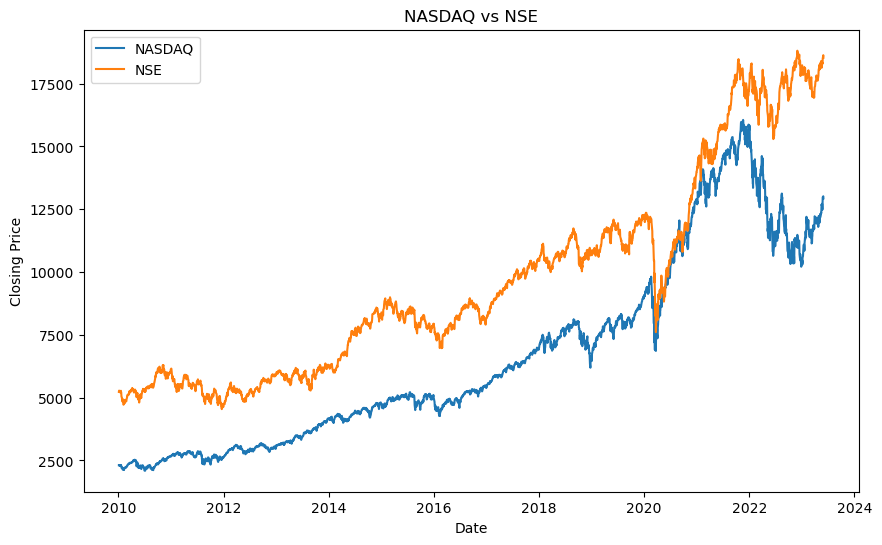

In [19]:
plt.figure(figsize=(10, 6))
plt.plot(nasdaq_data.index, nasdaq_data.values, label='NASDAQ')
plt.plot(nse_data.index, nse_data.values, label='NSE')
plt.xlabel('Date')
plt.ylabel('Closing Price')
plt.title('NASDAQ vs NSE')
plt.legend()
plt.show()

In [35]:
from scipy.signal import correlate

# Normalize the indices data
normalized_nasdaq = (nasdaq_data - nasdaq_data.mean()) / nasdaq_data.std()
normalized_nse = (nse_data - nse_data.mean()) / nse_data.std()

# Calculate cross-correlation
cross_corr = correlate(normalized_nasdaq, normalized_nse, mode='full')

# Find the lag with the highest correlation
lead_lag = np.argmax(cross_corr) - (len(nasdaq_data) - 1)

if lead_lag > 0:
    print("NSE leads NASDAQ by", -lead_lag, "days.")
elif lead_lag < 0:
    print("NASDAQ leads NSE by", lead_lag, "days.")
else:
    print("NASDAQ and NSE are synchronized.")

NASDAQ leads NSE by -70 days.


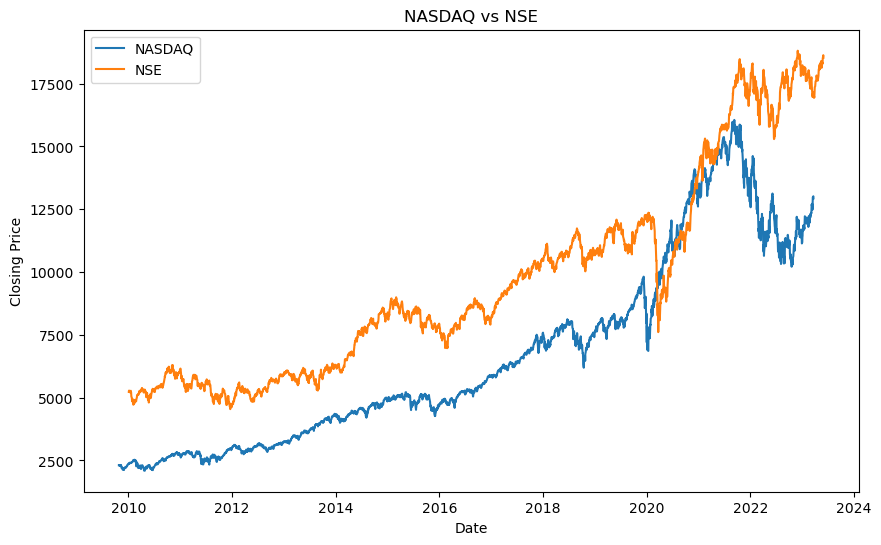

In [36]:
plt.figure(figsize=(10, 6))
plt.plot(nasdaq_data.index - pd.DateOffset(days=70), nasdaq_data.values, label='NASDAQ')
plt.plot(nse_data.index, nse_data.values, label='NSE')
plt.xlabel('Date')
plt.ylabel('Closing Price')
plt.title('NASDAQ vs NSE')
plt.legend()
plt.show()

In [28]:
data = yf.download(['^IXIC', '^NSEI'], start=start_date, end=end_date)['Adj Close']
def calculate_keltner_channel(data, window=20, atr_win=10, atr_multiplier=2):
    # Calculate True Range (TR)
    data['H-L'] = data['High'] - data['Low']
    data['H-PC'] = abs(data['High'] - data['Close'].shift(1))
    data['L-PC'] = abs(data['Low'] - data['Close'].shift(1))
    data['TR'] = data[['H-L', 'H-PC', 'L-PC']].max(axis=1)
    
    # Calculate Average True Range (ATR)
    data['ATR'] = data['TR'].ewm(atr_win).mean()
    
    # Calculate Keltner Channel
    data['KCUpperBand'] = data['Close'].ewm(window).mean() + atr_multiplier * data['ATR']
    data['KCLowerBand'] = data['Close'].ewm(window).mean() - atr_multiplier * data['ATR']
    data['KCMiddleBand'] = data['Close'].ewm(window).mean()
    
    return data[['KCUpperBand', 'KCMiddleBand', 'KCLowerBand']]

def calculate_bollinger_bands(data, window=20, num_std=2):
    # Calculate SMA and Standard Deviation
    sma = data['Close'].rolling(window).mean()
    std_dev = data['Close'].rolling(window).std()
    
    # Calculate Bollinger Bands
    data['BUpperBand'] = sma + num_std * std_dev
    data['BLowerBand'] = sma - num_std * std_dev
    
    return data[['BUpperBand', 'BLowerBand']]

def calculate_macd(data, short_window=12, long_window=26, signal_window=9):
    # Calculate Exponential Moving Averages (EMA)
    ema_short = data['Close'].ewm(short_window).mean()
    ema_long = data['Close'].ewm(long_window).mean()
    
    # Calculate MACD Line
    macd_line = ema_short - ema_long
    
    # Calculate Signal Line
    signal_line = macd_line.ewm(signal_window).mean()
    
    # Calculate MACD Histogram
    macd_histogram = macd_line - signal_line
    
    data['MACD_Line'] = macd_line
    data['Signal_line'] = signal_line
    data['MACD_Histogram'] = macd_histogram
    
    return data[['MACD_Line', 'Signal_line', 'MACD_Histogram']]

[*********************100%***********************]  2 of 2 completed


In [30]:
returns = data.pct_change()
cumulative_returns = (1 + returns).cumprod() - 1

Risk_free_rates = [0.0353, 0.0353]
excess_returns = returns*255 - Risk_free_rates
annual = returns*255
sharpe_ratio = excess_returns.mean() / (returns.std() * np.sqrt(252))

peak_value = data.max()
trough_value = data.min()
max_drawdowns = (trough_value - peak_value)/peak_value

In [31]:
metrics = pd.DataFrame({
    'Cumulative Returns': cumulative_returns.iloc[-1],
    'Max Drawdown': max_drawdowns,
    'Sharpe Ratio': sharpe_ratio,
})

print(metrics)

       Cumulative Returns  Max Drawdown  Sharpe Ratio
^IXIC            4.603526     -0.869731      0.554505
^NSEI            2.542372     -0.758448      0.430412
